## Exploratory analysis of Transit Peace Officer call data

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sys
import os
from config import eda_tpo_calls_defaults

# Add the subfolder containing the Python file to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'calgary_project')))
import eda_plot_funcs as epf
from eda_plot_funcs import plot_yearly_sum_trend, plot_seasonal_and_total_trends
import other_funcs 


In [43]:
# Set default values for plotting functions
defaults_yearly = eda_tpo_calls_defaults['plot_yearly_sum_trend']
defaults_seasonal = eda_tpo_calls_defaults['plot_seasonal_and_total_trends']

Load and check out data.

In [44]:
# Load the CSV file instead
file_path = "../data/raw/transit_peace_officer_calls.csv"

df = pd.read_csv(file_path, parse_dates=['date'])
df.head()

,activity_number,date,year,month,day,call_source,call_category_call_category_name,source
0,ACT-2016-025162,2016-11-30,2016,11,30,On View (Officer),Situation / Incident / Unwanted Person,Proactive
1,ACT-2016-025161,2016-11-30,2016,11,30,Bus Control,Situation / Incident / Unwanted Person,Transit
2,ACT-2016-025160,2016-11-30,2016,11,30,Rail Control,Situation / Subject / Check on Welfare,Transit
3,ACT-2016-025159,2016-11-30,2016,11,30,CCTV,Situation / Subject / Check on Welfare,Transit
4,ACT-2016-025158,2016-11-30,2016,11,30,CCTV,Situation / Subject / Check on Welfare,Transit


Let's see what total `call_category_call_category_name` counts over the years look.

<Axes: xlabel='year'>

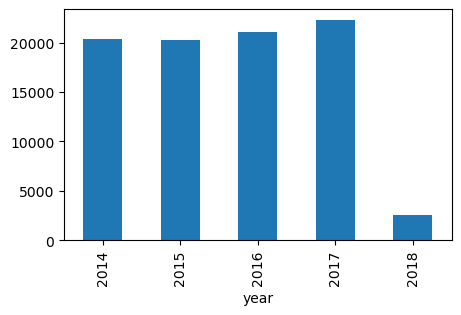

In [45]:
# plot the trend over the years
df.groupby(['year'])['call_category_call_category_name'].count().plot(kind='bar', figsize=(5, 3))

It looks like there is a slight upwards trend in reports and the 2018 data appears incomplete.

In [46]:
# exclude 2018 as this only contributes one month
df[(df.year == 2018) ].value_counts('month')

month
1    2560
Name: count, dtype: int64

Let's remove this 2018 as it only contributes 1 month.

In [47]:
df = df[df.year != 2018]

The call_source/source might be important. Let's see where most reports come from.

In [48]:
df.groupby(['call_source','source'])['call_category_call_category_name'].count().sort_values(ascending=False)

call_source                source   
Rail Control               Transit      19820
On View (Officer)          Proactive    16498
Calgary Police Service     Transit      12251
Bus Control                Transit      10382
CCTV                       Transit       9356
Help Phones                Public        5215
CT Employee                Transit       2646
Transit Watch              Public        2373
General Public             Public        1381
Twitter                    Public        1138
Not Classified             Transit        968
External Division Call In  Transit        762
Internal Security Request  Transit        737
Phone                      Public         280
Alarm                      Transit        123
Not Classifed              Transit         58
Workflow Notification      Transit         22
Email                      Transit         13
rail Control               Transit          1
Name: call_category_call_category_name, dtype: int64

Most reports come from official sources, but `Public` reports should be a good reflection of people's perception of safety when using the transit system.
<br>Let's look through the categories to see if there are violence/disturbance of the public or individuals related categories. 

In [49]:
df[df.source == 'Public'].call_category_call_category_name.sort_values(ascending=True).unique()

array(['Accident / Injury', 'Accident / Other', 'Accident / Other / Bus',
       'Accident / Property Damage', 'Accident / Property Damage / Bus',
       'Accident / Property Damage / LRV',
       'Accident / Property Damage / Non-CT Related',
       'Coded Emergency / Abduction / Adult',
       'Coded Emergency / Bomb Call', 'Coded Emergency / Sexual Assault',
       'Coded Emergency / Suicide Complaint',
       'Coded Emergency / Suicide Event', 'Coded Emergency / Theft',
       'Coded Emergency / Weapon Involved', 'Customer Service Request',
       'Enforcement', 'Farebox / Fare collection', 'Miscellaneous Call',
       'Miscellaneous Call / Animal Complaint',
       'Miscellaneous Call / Assist Plain Clothes Unit',
       'Miscellaneous Call / Incident',
       'Miscellaneous Call / Incident / Hazardous Goods Spill',
       'Miscellaneous Call / Miscellaneous',
       'Miscellaneous Call / Notification',
       'Miscellaneous Call / Notification / from Police',
       'Miscellaneou

Since there as so many different categories, let's use GPT4 to sort the `call_category_call_category_name`and remove categories that are rather related with accidents or non-crime related categories.

In [50]:
crime_or_disturbance_cats  = [
                                'Coded Emergency / Abduction / Adult',
                                'Coded Emergency / Bomb Call',
                                'Coded Emergency / Sexual Assault',
                                'Coded Emergency / Suicide Complaint',
                                'Coded Emergency / Suicide Event',
                                'Coded Emergency / Theft',
                                'Coded Emergency / Weapon Involved',
                                'Miscellaneous Call / Shoplifter',
                                'Miscellaneous Call / Suspicious Package',
                                'Miscellaneous Call / Suspicious Person',
                                'Miscellaneous Call / Threats',
                                'Situation / Assault',
                                'Situation / Incident / Disturbance',
                                'Situation / Incident / Domestic',
                                'Situation / Incident / Drugs',
                                'Situation / Incident / Graffiti',
                                'Situation / Incident / Indecent Act',
                                'Situation / Incident / Intoxication',
                                'Situation / Incident / Juvenile Complaint',
                                'Situation / Incident / Property Damage',
                                'Situation / Incident / Purse Snatch',
                                'Situation / Incident / Robbery',
                                'Situation / Incident / Unwanted Person',
                                'Situation / Subject / Dangerous',
                                'Situation / Subject / Prowler',
                                'Situation / Subject / Wanted',
                                'Situation / Vehicle / Drunk Driver',
                                'Situation / Vehicle / Hit & Run',
                                'Situation / Vehicle / Stolen Auto',
                                'Situation / Vehicle / Suspicious Auto'
                                'Situation / Incident / Noise Complaint',
                                'Situation / Subject / Check on Welfare',
                                'Situation / Subject / Mental Patient',
                            ]

removed_cats = [
                'Situation / Assault / Code Blue',
                'Accident / Injury',
                'Accident / Other',
                'Accident / Other / Bus',
                'Accident / Property Damage',
                'Accident / Property Damage / Bus',
                'Accident / Property Damage / LRV',
                'Accident / Property Damage / Non-CT Related',
                'Customer Service Request',
                'Enforcement',
                'Farebox / Fare collection',
                'Miscellaneous Call',
                'Miscellaneous Call / Animal Complaint',
                'Miscellaneous Call / Assist Plain Clothes Unit',
                'Miscellaneous Call / Incident',
                'Miscellaneous Call / Incident / Hazardous Goods Spill',
                'Miscellaneous Call / Miscellaneous',
                'Miscellaneous Call / Notification',
                'Miscellaneous Call / Notification / from Police',
                'Situation',
                'Situation / Alarm',
                'Situation / Assist Peace Officer',
                'Situation / Incident / Escort\\Transport',
                'Situation / Incident / Fire',
                'Situation / Incident / Lost and Found',
                'Situation / Incident / Smoke',
                'Situation / Incident / Toxic Fumes',
                'Situation / Subject',
                'Situation / Subject / Indentification Requested',
                'Situation / Subject / Missing Person',
                'Situation / Vehicle / Abandoned Auto',
                'Situation / Vehicle / Parking Complaint'
            ]


In [51]:
public = df[df.source == 'Public']
pub_rep_crime_dist = public[public.call_category_call_category_name.isin(crime_or_disturbance_cats)]
pub_rep_crime_dist


,activity_number,date,year,month,day,call_source,call_category_call_category_name,source
5,ACT-2016-025157,2016-11-30,2016,11,30,Twitter,Situation / Incident / Unwanted Person,Public
11,ACT-2016-025151,2016-11-30,2016,11,30,Help Phones,Situation / Incident / Unwanted Person,Public
12,ACT-2016-025150,2016-11-30,2016,11,30,Transit Watch,Situation / Incident / Unwanted Person,Public
20,ACT-2016-025142,2016-11-30,2016,11,30,Help Phones,Situation / Incident / Disturbance,Public
22,ACT-2016-025140,2016-11-30,2016,11,30,Transit Watch,Situation / Incident / Unwanted Person,Public
...,...,...,...,...,...,...,...,...
86527,ACT-2017-000056,2017-01-02,2017,1,2,Help Phones,Situation / Incident / Unwanted Person,Public
86541,ACT-2017-000043,2017-01-01,2017,1,1,Help Phones,Coded Emergency / Theft,Public
86550,ACT-2017-000034,2017-01-01,2017,1,1,Transit Watch,Situation / Incident / Graffiti,Public
86572,ACT-2017-000012,2017-01-01,2017,1,1,Help Phones,Situation / Assault,Public


In [52]:
sum_crime_per_month = pub_rep_crime_dist.groupby(['year', 'month'])['activity_number'].count().reset_index()
yearly_sum = sum_crime_per_month.groupby('year')['activity_number'].sum().reset_index()


sum_crime_per_month = other_funcs.get_seasons(sum_crime_per_month)

Let's explore how reporting of those categories changed from 2014 to 2017.

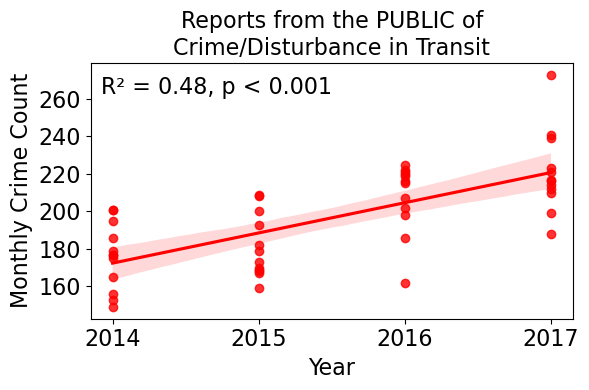

In [53]:
plot_yearly_sum_trend(sum_crime_per_month, title="Reports from the PUBLIC of\nCrime/Disturbance in Transit", color='red', category='PUBLIC', save_png=True, **defaults_yearly)

Looks like there is an upward trend of reports of crime/disturbance from the public. Let's check if there is a seasonal trend.

In [54]:
sum_crime_per_month.head()

,year,month,activity_number,season
0,2014,1,186,Winter
1,2014,2,201,Winter
2,2014,3,201,Spring
3,2014,4,175,Spring
4,2014,5,177,Spring


c:\Users\gotat\Documents\python\portfolio\calgary\calgary_project\calgary_project\eda_plot_funcs.py:93: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.lineplot(ax=ax1, data=seasonal_trends, x='year', y=y, hue='season', estimator='sum', palette=palette, markers=True, linewidth=3, markersize=10, style='season')


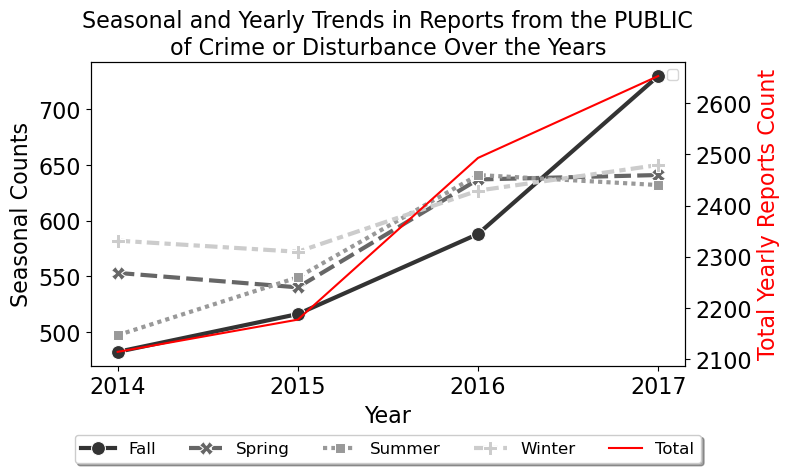

In [55]:
plot_seasonal_and_total_trends(sum_crime_per_month, yearly_sum, 'Seasonal and Yearly Trends in Reports from the PUBLIC\nof Crime or Disturbance Over the Years', save_png=True, population='PUBLIC', **defaults_seasonal)

While in 2014 `Winter` was the prime season for peak reporting by the public and switched to `Fall` in 2017. Let's check out crime/disturbance categories from all sources.

In [56]:
all_crime_dist_cats = [
    'Coded Emergency / Abduction / Adult',
    'Coded Emergency / Bomb Call',
    'Coded Emergency / Extortion\\Hostage Situation',
    'Coded Emergency / Firearm',
    'Coded Emergency / Major Disturbance',
    'Coded Emergency / Major Incident',
    'Coded Emergency / Officer in Trouble',
    'Coded Emergency / Sexual Assault',
    'Coded Emergency / Sudden Death',
    'Coded Emergency / Suicide Complaint',
    'Coded Emergency / Suicide Event',
    'Coded Emergency / Theft',
    'Coded Emergency / Weapon Involved',
    'Miscellaneous Call / Shoplifter',
    'Miscellaneous Call / Suspicious Person',
    'Miscellaneous Call / Threats',
    'Situation / Assault',
    'Situation / Assault / Code Blue',
    'Situation / Incident / Disturbance',
    'Situation / Incident / Domestic',
    'Situation / Incident / Drugs',
    'Situation / Incident / Fraud',
    'Situation / Incident / Graffiti',
    'Situation / Incident / Indecent Act',
    'Situation / Incident / Intoxication',
    'Situation / Incident / Juvenile Complaint',
    'Situation / Incident / Noise Complaint',
    'Situation / Incident / Obstruction',
    'Situation / Incident / Other Criminal Code',
    'Situation / Incident / Possible Gun Shots',
    'Situation / Incident / Property Damage',
    'Situation / Incident / Provincial Statute Offences',
    'Situation / Incident / Purse Snatch',
    'Situation / Incident / Robbery',
    'Situation / Incident / Smoke',
    'Situation / Incident / Toxic Fumes',
    'Situation / Incident / Unwanted Person',
    'Situation / Subject / Dangerous',
    'Situation / Subject / Possibly Wanted',
    'Situation / Subject / Prowler',
    'Situation / Subject / Wanted',
    'Situation / Vehicle / Crime Vehicle',
    'Situation / Vehicle / Drunk Driver',
    'Situation / Vehicle / Hit & Run',
    'Situation / Vehicle / Stolen Auto',
    'Situation / Vehicle / Suspicious Auto'
    'Situation / Subject / Check on Welfare',
    'Situation / Subject / Mental Patient',
]

removed_categories = [
    'Situation / Break & Enter / House',
    'Situation / Break & Enter / Shop',
    'Miscellaneous Call / Suspicious Package',
    'Accident',
    'Accident / Injury',
    'Accident / Injury / Bus',
    'Accident / Injury / LRV',
    'Accident / Injury / Non-CT Related',
    'Accident / Injury / Other City Vehicle',
    'Accident / Other',
    'Accident / Other / Bus',
    'Accident / Other / Facility',
    'Accident / Other / LRV',
    'Accident / Other / Non-CT Related',
    'Accident / Property Damage',
    'Accident / Property Damage / Bus',
    'Accident / Property Damage / Facility',
    'Accident / Property Damage / LRV',
    'Accident / Property Damage / Non-CT Related',
    'Accident / Property Damage / Other City Vehicle',
    'Coded Emergency',
    'Customer Service Request',
    'Customer Service Request / Investigation',
    'Customer Service Request / Investigation / Case open',
    'Customer Service Request / Investigation / Report back to customer',
    'Enforcement',
    'Enforcement / High Enforcement Team',
    'Farebox',
    'Farebox / Fare collection',
    'Miscellaneous Call',
    'Miscellaneous Call / Animal Complaint',
    'Miscellaneous Call / Assist Plain Clothes Unit',
    'Miscellaneous Call / Bylaw Offences',
    'Miscellaneous Call / Incident',
    'Miscellaneous Call / Incident / Hazardous Goods Spill',
    'Miscellaneous Call / Miscellaneous',
    'Miscellaneous Call / Notification',
    'Miscellaneous Call / Notification / from Police',
    'Miscellaneous Call / Nuisance Telephone Calls',
    'Situation',
    'Situation / Activity',
    'Situation / Alarm',
    'Situation / Assist Peace Officer',
    'Situation / Incident',
    'Situation / Incident / Collapse',
    'Situation / Incident / Escort\\Transport',
    'Situation / Incident / Fire',
    'Situation / Incident / Lost and Found',
    'Situation / Subject',
    'Situation / Subject / Indentification Requested',
    'Situation / Subject / Missing Person',
    'Situation / Vehicle / Abandoned Auto',
    'Situation / Vehicle / Careless Driver',
    'Situation / Vehicle / Parking Complaint'
]

all_crime_dist = df[df.call_category_call_category_name.isin(all_crime_dist_cats)]
all_crime_dist

,activity_number,date,year,month,day,call_source,call_category_call_category_name,source
0,ACT-2016-025162,2016-11-30,2016,11,30,On View (Officer),Situation / Incident / Unwanted Person,Proactive
1,ACT-2016-025161,2016-11-30,2016,11,30,Bus Control,Situation / Incident / Unwanted Person,Transit
5,ACT-2016-025157,2016-11-30,2016,11,30,Twitter,Situation / Incident / Unwanted Person,Public
9,ACT-2016-025153,2016-11-30,2016,11,30,On View (Officer),Situation / Subject / Wanted,Proactive
11,ACT-2016-025151,2016-11-30,2016,11,30,Help Phones,Situation / Incident / Unwanted Person,Public
...,...,...,...,...,...,...,...,...
86571,ACT-2017-000013,2017-01-01,2017,1,1,Rail Control,Situation / Incident / Disturbance,Transit
86572,ACT-2017-000012,2017-01-01,2017,1,1,Help Phones,Situation / Assault,Public
86576,ACT-2017-000008,2017-01-01,2017,1,1,On View (Officer),Situation / Incident / Disturbance,Proactive
86577,ACT-2017-000007,2017-01-01,2017,1,1,Bus Control,Situation / Incident / Unwanted Person,Transit


In [57]:
all_sum_crime_per_month = all_crime_dist.groupby(['year', 'month'])['activity_number'].count().reset_index()
all_sum_crime_per_month = other_funcs.get_seasons(all_sum_crime_per_month)
all_yearly_sum = all_sum_crime_per_month.groupby('year')['activity_number'].sum().reset_index()
all_yearly_sum

,year,activity_number
0,2014,8083
1,2015,7458
2,2016,7848
3,2017,8003


Surprisingly, there is no upwards trend in crime/disturbance categories reported by all sources, nor is there a clear trend for any of the seasons.

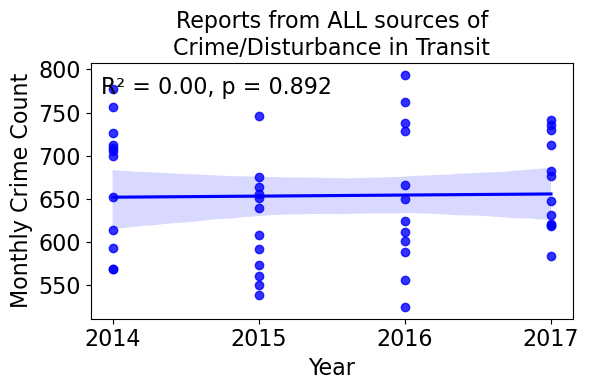

c:\Users\gotat\Documents\python\portfolio\calgary\calgary_project\calgary_project\eda_plot_funcs.py:93: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.lineplot(ax=ax1, data=seasonal_trends, x='year', y=y, hue='season', estimator='sum', palette=palette, markers=True, linewidth=3, markersize=10, style='season')


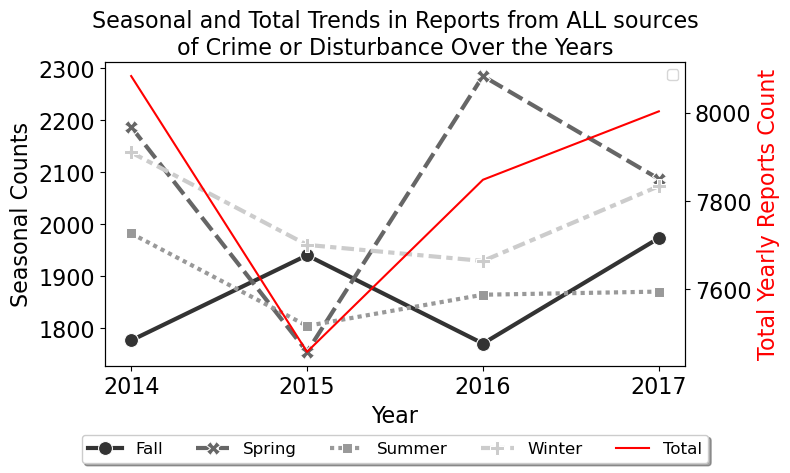

In [58]:
plot_yearly_sum_trend(all_sum_crime_per_month, "Reports from ALL sources of\nCrime/Disturbance in Transit",  color='blue', category='ALL', save_png=True, **defaults_yearly)
plot_seasonal_and_total_trends(all_sum_crime_per_month, all_yearly_sum,'Seasonal and Total Trends in Reports from ALL sources\nof Crime or Disturbance Over the Years',  save_png=True, **defaults_seasonal)

There is no overall increase in reporting from all sources but specifically reporting by the public steadily increased from 2014 to 2017.
